# Pouya Sharifi
### Data wrangling practice using Seattle Airbnb data

##### March 2020 

In [1]:
### import the libraries
import numpy as np
import random, os, sys
import pandas as pd
import scipy

from datetime import datetime

import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

%matplotlib inline

In [2]:
### import the listings and calendar data sets
listing = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')

## get the shape of the dataset
print('Dataset has %d rows and %d columns.\n' %listing.shape)

Dataset has 3818 rows and 92 columns.



## Data Cleaning
We need to clean the data for the price-related columns, as they are treated as strings starting with \$ sign. I define a function that converts a possible price_related string to a float.

In [3]:
def convert_price_to_num(s):
    '''
    this function takes a string as input
    removes $ sign and comma (,) from the string
    convert the string to float if possible, otherwise returns the string
    '''
    try:
        return float(s.replace('$','').replace(',', ''))
    except:
        return s

In [4]:
for col in listing.select_dtypes(include='object').columns:  
    listing[col] = listing[col].apply(convert_price_to_num)

## Question 1:
#### Is there any variation in price, price per accommodate, number of listings in Seattle Neighbourhoods?


Text(0.5, 0, 'Neighbourhood')

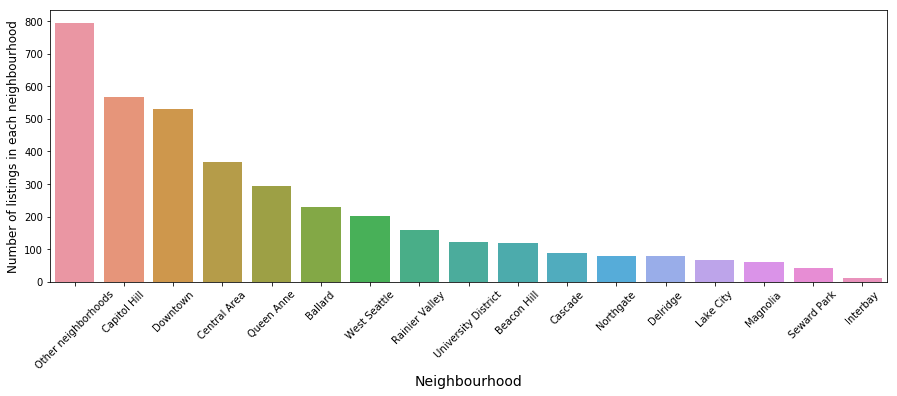

In [5]:
plt.figure(figsize = (15,5))
sns.barplot(x = listing['neighbourhood_group_cleansed'].value_counts().index,
            y = listing['neighbourhood_group_cleansed'].value_counts())
plt.ylabel('Number of listings in each neighbourhood', fontsize= 12)
plt.xticks(rotation=45)
plt.xlabel('Neighbourhood', fontsize=14)

We see that some neighborhood in central Seattle (Capitol Hill, Downtown, Central Area) have the largest number of listings across all neighborhoods. To get a sense of these neighborhoods, lets take a look at each seattle neighborhood and listings in Seattle map.

C:\Users\pouya\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


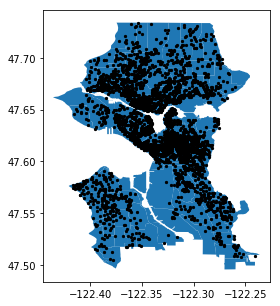

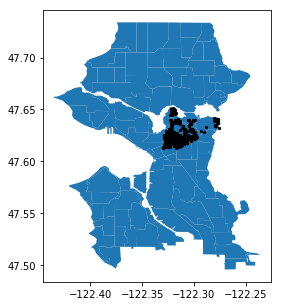

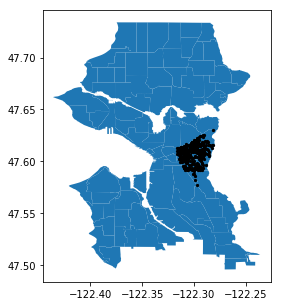

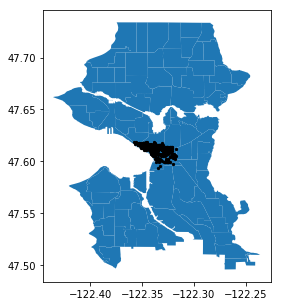

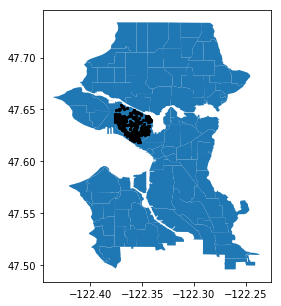

In [6]:
mapdata= listing.dropna(subset=['latitude', 'longitude'])

geometry = [Point(xy) for xy in zip(mapdata['longitude'], mapdata['latitude'])]
gdf = GeoDataFrame(mapdata, geometry=geometry)

# load seattle shape
cities = gpd.read_file('City_Clerk_Neighborhoods.shp')
seattle = cities.loc[cities['L_HOOD'].isnull() == False]
seattle['L_HOOD'] = seattle['L_HOOD'].replace('NO BROADER TERM', 'OTHER NEIGHBORHOODS')
seattle_shp = seattle.loc[:, 'geometry']

gdf.plot(ax=seattle.plot(figsize=(18,5)), marker='o', color='black', markersize=5)

for i, n in enumerate(['Capitol Hill', 'Central Area', 'Downtown', 'Queen Anne']):
    new_map = mapdata[mapdata['neighbourhood_group_cleansed'] == n]
    geometry = [Point(xy) for xy in zip(new_map['longitude'], new_map['latitude'])]
    gdf = GeoDataFrame(new_map, geometry=geometry)
    gdf.plot(ax=seattle.plot(figsize=(18,5), legend= True), 
             marker='o', color='black', markersize=5, facecolor = 'k')

As seen in this plot, most of the listings are concentrated in the Central Seattle area with “Capitol hill”, “Downtown”, and “Central Area” having the largest number of listings (see figure below) all in the central Seattle.

Now let's take a look at the price per accommodate for each neighborhood

In [9]:
## create a column for price per accommodate
listing['price_per_accomodate'] = listing['price']/ listing['accommodates']

listing_price = listing.groupby('neighbourhood_group_cleansed').mean()[['price', 'price_per_accomodate']]

In [10]:
listing_price

,price,price_per_accomodate
neighbourhood_group_cleansed,,
Ballard,124.682609,37.774156
Beacon Hill,94.669492,35.453571
Capitol Hill,130.592593,46.814611
Cascade,140.101124,48.767322
Central Area,128.338753,39.594547
Delridge,83.278481,31.179536
Downtown,154.405660,47.829774
Interbay,109.727273,50.772727
Lake City,92.671642,38.123010


Text(0.5, 0, 'Neighbourhood')

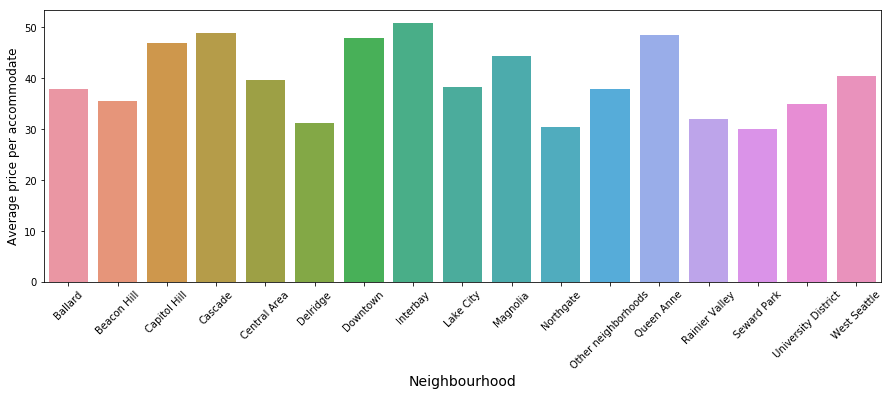

In [11]:
plt.figure(figsize=(15,5))
sns.barplot(x = listing_price.index,
            y = listing_price['price_per_accomodate'])
plt.ylabel('Average price per accommodate', fontsize= 12)
plt.xticks(rotation=45)
plt.xlabel('Neighbourhood', fontsize=14)

Independent t-test is done to check whether the difference in prices are statistically significant or not.

In [12]:
Neighbourhoods = listing['neighbourhood_group_cleansed'].unique()

for i , j  in combinations(Neighbourhoods,2):
    a = listing[listing['neighbourhood_group_cleansed'] == i]['price_per_accomodate']
    b = listing[listing['neighbourhood_group_cleansed'] == j]['price_per_accomodate']
    T, p_val = scipy.stats.ttest_ind(a, b, axis=0, equal_var=False)
    if p_val <= 0.05/ (2**17):
        print(f'price per accomodate for {i} and {j} are significantly different.')

price per accomodate for Queen Anne and Ballard are significantly different.
price per accomodate for Queen Anne and Other neighborhoods are significantly different.
price per accomodate for Queen Anne and Central Area are significantly different.
price per accomodate for Queen Anne and University District are significantly different.
price per accomodate for Queen Anne and Beacon Hill are significantly different.
price per accomodate for Queen Anne and Rainier Valley are significantly different.
price per accomodate for Queen Anne and Delridge are significantly different.
price per accomodate for Queen Anne and Seward Park are significantly different.
price per accomodate for Queen Anne and Northgate are significantly different.
price per accomodate for Ballard and Downtown are significantly different.
price per accomodate for Ballard and Capitol Hill are significantly different.
price per accomodate for Other neighborhoods and Downtown are significantly different.
price per accomodat

To compare the price per accommodates of each neighborhoods, I conducted independent t-test for each pair of the neighborhood groups. p-value of 0.01 was used to test if a sample mean is significantly larger that another sample mean. The analysis implies that neighborhoods of “Capitol Hill”, “Cascade”, “Downtown”, “Interbay”, and “Queen Anne” are significantly more expensive places to rent than other neighborhoods away from central Seattle.

Now, let's find out the most common property type in each neighborhood

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

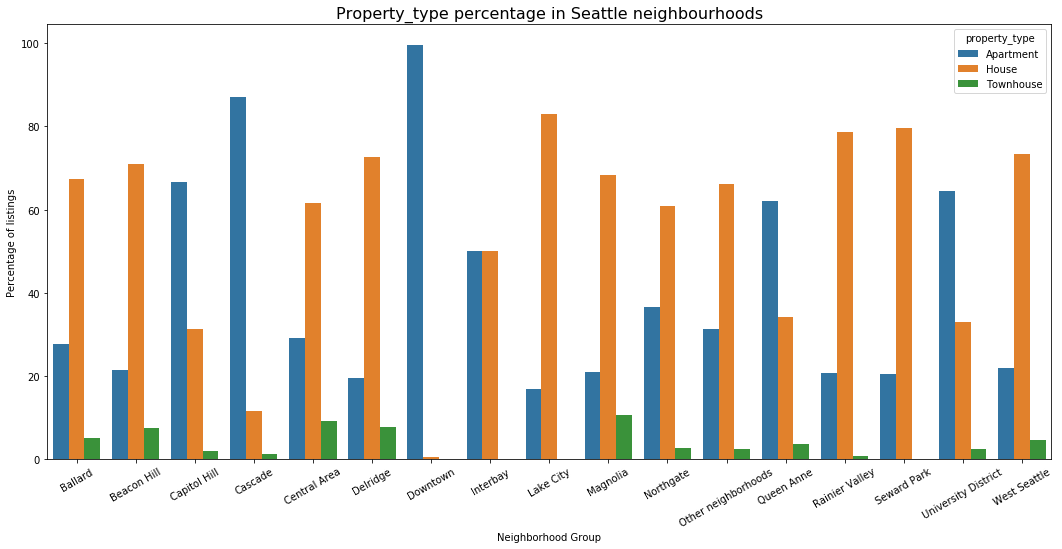

In [13]:
### only filter the data by common property types houses, apartments, and townhouses
### get the count of each type in all neighbourhoods
neighborhood_property = (listing[listing['property_type'].isin(['Apartment', 'House', 'Townhouse'])]
                                .groupby(['neighbourhood_group_cleansed', 'property_type']).size())

### take the proportion of each property_type in a neighbourhood
neighborhood_property = (neighborhood_property.groupby(level = 0)
                         .apply(lambda x: 100 * x /float(x.sum()))
                        .reset_index())

### Plot the neighbourhoods and the proportion of listings in each property_type category
plt.figure(figsize = (18,8))
sns.barplot(x = 'neighbourhood_group_cleansed', y = 0, hue= 'property_type', data= neighborhood_property)
plt.title('Property_type percentage in Seattle neighbourhoods', fontsize= 16)
plt.xlabel('Neighborhood Group')
plt.ylabel('Percentage of listings')
plt.xticks(rotation= 30)

Let's take a look at the summary of the data grouped by neighbourhood

In [14]:
listing_price = listing.groupby('neighbourhood_group_cleansed').mean()[['price', 'bedrooms','accommodates', 
                                                                        'review_scores_rating','price_per_accomodate']]

listing_price = pd.concat([listing_price, listing.groupby('neighbourhood_group_cleansed').size()], axis=1)

### get the most frequent property type in each neighborhood
listing_price= pd.concat([listing_price, listing.groupby('neighbourhood_group_cleansed')['property_type'].agg(pd.Series.mode)]
                          , axis=1)
## rename the columns
listing_price.rename(columns = {0: '#Listings', 'property_type': 'most frequent property type'})

,price,bedrooms,accommodates,review_scores_rating,price_per_accomodate,#Listings,most frequent property type
neighbourhood_group_cleansed,,,,,,,
Ballard,124.682609,1.434783,3.443478,95.533679,37.774156,230,House
Beacon Hill,94.669492,1.262712,2.991525,94.019417,35.453571,118,House
Capitol Hill,130.592593,1.139823,2.989418,94.184783,46.814611,567,Apartment
Cascade,140.101124,1.101124,2.921348,92.461538,48.767322,89,Apartment
Central Area,128.338753,1.436314,3.509485,96.009404,39.594547,369,House
Delridge,83.278481,1.215190,2.860759,95.861538,31.179536,79,House
Downtown,154.405660,1.062619,3.566038,93.958333,47.829774,530,Apartment
Interbay,109.727273,1.090909,2.363636,93.777778,50.772727,11,"[Apartment, House]"
Lake City,92.671642,1.253731,2.701493,94.375000,38.123010,67,House


_____________________________________________________________________________________________________________________

# Question 2:
### How much discount should you expect from an owner if you rent a house for a week or a month?

In order to address this question, we need to make a few assumptions. I assume that if you rent a place for more than one day, the cleaning fee is the same regardless of number of nights you stay there. I also assume that the data with Null values for cleaning_fee column, the cleaning fee is included in the price. Thus, I filled the missing values for that column with value 0.

In [15]:
listing['cleaning_fee'].fillna(0, inplace = True)    ### assuming that cleaning fee with missing value equals to 0

### Assuming that cleaning fee is only applied at the end of the stay and is the same for one-day or weekly stays.
listing.loc[:,'weekly_discount'] = 100*(listing['price']*7 + listing['cleaning_fee'] 
                                   - listing['weekly_price'])/(listing['price']*7 + listing['cleaning_fee'])

listing.loc[:,'monthly_discount'] = 100*(listing['price']*30 + listing['cleaning_fee'] 
                                   - listing['monthly_price'])/(listing['price']*30 + listing['cleaning_fee'])

In [16]:
listing[['weekly_discount', 'monthly_discount']].describe()

,weekly_discount,monthly_discount
count,2009.000000,1517.000000
mean,11.638527,27.007023
std,18.106609,21.330059
min,-125.165563,-360.461538
25%,5.100830,18.032787
50%,14.141414,29.629630
75%,21.052632,39.034307
max,64.516129,82.222222


By looking at the some description for these two columns, we see that there are some negative discount values and also the variation is so high. I decided to remove those rows with negative discounts as they might be invalid input by the owners.

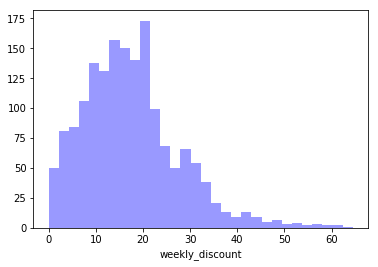

In [17]:
sns.distplot(listing[listing['weekly_discount'] >=0]['weekly_discount'],color='b', kde = False, bins= 30)

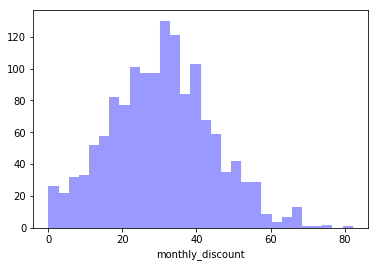

In [18]:
sns.distplot(listing[listing['monthly_discount'] >=0]['monthly_discount'], color='b', kde = False, bins= 30)

For places that provide the monthly and weekly prices for rent, assuming that one-time cleaning fee is applied if you rent a place for a week or a month, our analysis shows that you can expect an average of 17% discount for a weekly rent and an average of 30% discount for monthly rent.
The weekly or monthly discounts that you could negotiate for renting a place does not depend much on the neighborhood group.

### Pandas Data Wrangling coding question:

Question: For each listing, find the total number of listings with the same host_url (as a new column called 'number_listing_host'). In other words, the total number of listings of each  

Solution: There are many possible ways to solve this problem. I found this solution easy to code and explain. First, we define a list as the keys being the unique host_url s, and the values are the number of counts that host_url appears in the data set.

In [19]:
dct = {k:v  for k, v in zip(listing['host_url'].value_counts().reset_index()['index'], 
                            listing['host_url'].value_counts().reset_index()['host_url'])}

Then, just simply get the value of our defined dictionary for each host_url as follows:

In [21]:
listing['number_listing_host'] = listing['host_url'].apply(lambda x: dct[x])

listing[['id', 'number_listing_host']].head()

,id,number_listing_host
0,241032,3
1,953595,6
2,3308979,2
3,7421966,1
4,278830,2


__________________________________________________________________________________________________________________________

# Question 3: Is there any trend in price and availablity throughout the year?

We need to import the Calendar dataset to see the price and availability of listings for each day of the year

In [22]:
calendar = pd.read_csv('calendar.csv')

calendar['available'] = calendar['available'].apply(lambda x: 1 if x=='t' else 0)

calendar_availability = (calendar.groupby('listing_id')['available'].
                         sum().reset_index())

In [23]:
calendar_availability.head()

,listing_id,available
0,3335,309
1,4291,365
2,5682,309
3,6606,365
4,7369,53


In [24]:
### merge the two data sets for the number of availabilities of each listing.
merged_df = pd.merge(calendar_availability, listing, left_on='listing_id', right_on= 'id')

availability_neighborhoods = merged_df.groupby('neighbourhood_group_cleansed')['available'].mean().reset_index()
availability_neighborhoods.rename(columns = {'neighbourhood_group_cleansed': 'neighborhood'})

,neighborhood,available
0,Ballard,252.673913
1,Beacon Hill,256.525424
2,Capitol Hill,233.982363
3,Cascade,210.303371
4,Central Area,245.409214
5,Delridge,272.721519
6,Downtown,237.216981
7,Interbay,308.545455
8,Lake City,280.611940
9,Magnolia,282.754098


In [25]:
## get the number of listings available for each date
available_by_date = calendar.groupby('date').sum()['available'].reset_index().sort_values(by='date')

available_by_date['date'] = pd.to_datetime(available_by_date['date'])

## get the month from the date column
available_by_date['month'] = available_by_date['date'].apply(lambda x: x.month)

## get week of the year from the date column
available_by_date['weekofyear'] = available_by_date['date'].apply(lambda x: x.week)

Text(2016-7-1, 2230, 'Warmest month \nof the year')

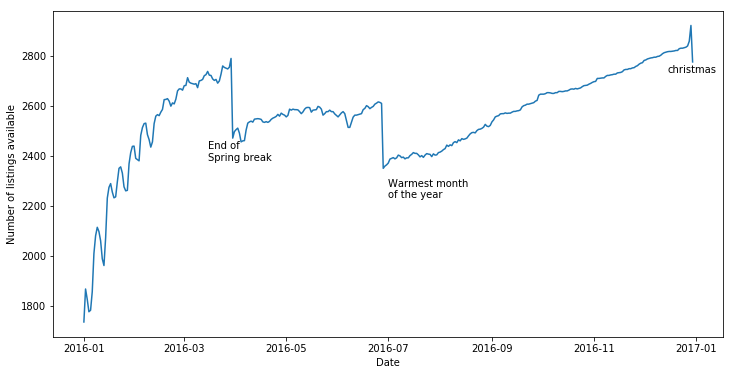

In [26]:
## plot the availability by date
plt.figure(figsize = (12,6))

plt.plot(pd.date_range(start='2016-01-01',end='2016-12-30'), 
        available_by_date.groupby('date').sum()['available'].values)
plt.ylabel('Number of listings available')
plt.xlabel('Date')
plt.text(x = '2016-12-15' , y =2730, s = 'christmas')
plt.text(x = '2016-3-15' , y =2380, s = 'End of \nSpring break')
plt.text(x = '2016-7-1' , y =2230, s = 'Warmest month \nof the year')

_____________________________________________________________________________________________________________________

I want to compare the average price in month for only the listings that have all 12 month records for price. We need to remove the listings that have price value of NaN in any month.

In [27]:
calendar['month'] = pd.to_datetime(calendar['date']).apply(lambda x: x.month)

calendar['price'] = calendar['price'].apply(convert_price_to_num)

price_month = calendar.groupby(['listing_id', 'month'])['price'].mean()

price_month = price_month.dropna(axis= 0).reset_index()

all_month = price_month.groupby('listing_id').size() == 12

price_month = price_month[price_month['listing_id'].isin(all_month[all_month == True].index)]

price_month.groupby('month').mean()['price']

month
1     123.754969
2     126.038844
3     130.928573
4     134.687668
5     138.981651
6     148.045234
7     151.606332
8     150.607769
9     142.382591
10    135.956181
11    134.674365
12    136.362231
Name: price, dtype: float64

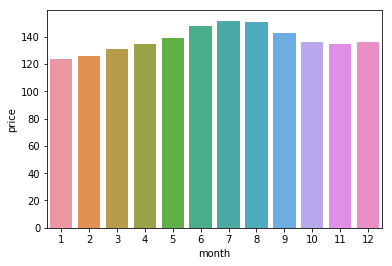

In [28]:
sns.barplot(price_month.groupby('month').mean()['price'].index, price_month.groupby('month').mean()['price'])

Text(0.5, 0, 'Date')

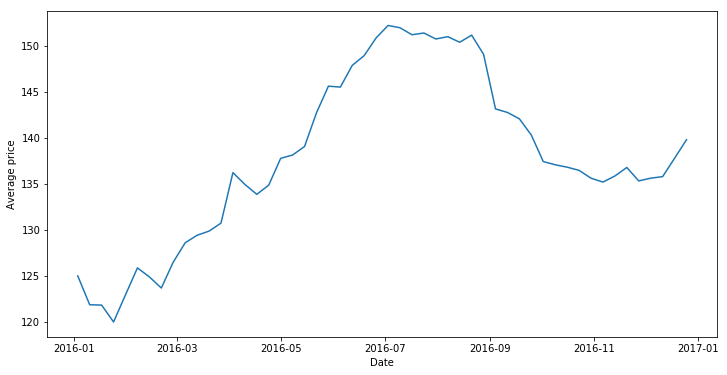

In [29]:
calendar['week_of_year'] = pd.to_datetime(calendar['date']).apply(lambda x: x.week)

price_by_date= calendar.groupby('week_of_year').mean()['price']
price_by_date.dropna(inplace=True)
plt.figure(figsize=(12,6))
plt.plot(pd.date_range(start='2016-01-01',freq='W', periods= 52), price_by_date)
plt.ylabel('Average price')
plt.xlabel('Date')

As seen in figures above, while the number of available listings decrease in July and August, we see that the average price peaks around these two months. One explanation to justify this contradiction might be that the hosts travel themselves out of Seattle, and as the supply decreases, the demand is still high enough that other hosts increase their prices.

__________________________________________________________________________________________________________________________

### Data Wrangling coding question:
Question: Compare the availability of the two neighborhood groups “Capitol Hill” and “West Seattle” in month July.

Solution: First, we need to extract the month from the date column in Calendar dataset. We can create a new data frame filtering the month of July (7) and sum the number of available days for each listing. Then, we merge the listing data frame with the newly created data frame mentioned. If we group the dataframe by the neighborhood and take the sum of availability, that would be an unfair comparison, since the number of listings in one neighborhood might be far greater than the other one. To make it a fair comparison, we need to divide the total sum of available listing days by the number of listings in each neighborhood. Or instead of taking the sum of availability, just simply take the average (that should do the same).

In [30]:
## 1) Again convert t to 1 and f to 0. so that you can apply arithmetic operation on it
calendar = pd.read_csv('calendar.csv')
calendar['available'] = calendar['available'].apply(lambda x: 1 if x =='t' else 0)

## 2) convert the date column to a date time and extract month from it.
calendar['month'] = pd.to_datetime(calendar['date']).apply(lambda x: x.month)

## 3) filter the data to only month of july
calendar_july = calendar[calendar['month'] == 7]

## 4) get the total availability
availability_july = calendar_july.groupby('listing_id')['available'].sum().reset_index()

## 5) Merge (join) the two data sets to get the number of days. Inner join is preferable since 
## we only care about listings in july
merged_df = pd.merge(availability_july, listing, left_on='listing_id', right_on= 'id', how='inner')
                     
## 6) filter the merged_df by the two neighborhoods in question
merged_df = merged_df[merged_df['neighbourhood_group_cleansed'].isin(['Capitol Hill', 'West Seattle'])]
                     
## 7) Group the merged_df by the 'neighbourhood_group_cleansed' 
##column and get the mean value on 'available' column
merged_df.groupby('neighbourhood_group_cleansed')['available'].mean()

neighbourhood_group_cleansed
Capitol Hill    18.650794
West Seattle    20.729064
Name: available, dtype: float64

# The End

In [140]:
import re

def text_process(mess):
    """
    remove punctuation
    remove common stop word
    return list of clean text words
    """
    mess = mess.replace('"', '').replace('{', '').replace('}', '')
    mess = mess.lower()
    return ' '.join(re.split(',', mess))

In [141]:
listing['amenitiess'] = listing['amenities'].apply(text_process)

In [194]:
listing['hasTV'] = listing['amenitiess'].apply(lambda x: 'tv' in x )
listing['hasInternet'] = listing['amenitiess'].apply(lambda x: 'internet' in x)
listing['hasFreeParking'] = listing['amenitiess'].apply(lambda x: 'free' in x and 'parking' in x)
listing['hasDryer'] = listing['amenitiess'].apply(lambda x: 'dryer' in x )
listing['hasWasher'] = listing['amenitiess'].apply(lambda x: 'washer' in x)
listing['hasHotTub'] = listing['amenitiess'].apply(lambda x: 'tub' in x)

In [195]:
listing['hasHotTub'].sum() /  len(listing)

0.07936092194866422

In [232]:
### answer the question, how is amenities distributed across different property types

In [80]:
## top 10 property types
apt_house_listing = listing[(listing['property_type'].isin(['Apartment', 'House', 'Townhouse'])) & 
                            (listing['neighbourhood'].isin(topNeighbourhoods))]

In [81]:
apt_house_listing.groupby('property_type')[['hasFreeParking', 'hasTV', 'hasInternet']].mean()

,hasFreeParking,hasTV,hasInternet
property_type,,,
Apartment,0.374737,0.755789,0.973684
House,0.637636,0.625194,0.986003
Townhouse,0.470588,0.803922,1.000000


In [82]:
apt_house_listing.groupby(['neighbourhood', 'property_type'])[['hasFreeParking', 'hasTV', 'hasInternet']].mean()

hasFreeParking     hasTV  hasInternet
neighbourhood       property_type                                       
Ballard             Apartment            0.517857  0.625000     0.964286
                    House                0.698529  0.647059     0.970588
                    Townhouse            0.300000  0.900000     1.000000
Belltown            Apartment            0.447514  0.906077     0.983425
                    House                1.000000  1.000000     1.000000
Capitol Hill        Apartment            0.220472  0.724409     0.964567
                    House                0.414634  0.463415     0.987805
                    Townhouse            0.500000  1.000000     1.000000
First Hill          Apartment            0.154639  0.793814     0.969072
Fremont             Apartment            0.513889  0.708333     0.986111
                    House                0.644068  0.661017     1.000000
                    Townhouse            0.500000  0.625000     1.000000
Minor               Apartment            0.490566  0.716981     0.981132
                    House                0.645455  0.627273     0.981818
                    Townhouse            0.500000  0.777778     1.000000
Queen Anne          Apartment            0.613636  0.852273     0.965909
                    House                0.797468  0.873418     0.987342
                    Townhouse            0.600000  1.000000     1.000000
Stevens             Apartment            0.500000  0.676471     1.000000
                    House                0.660000  0.580000     0.980000
                    Townhouse            0.333333  0.666667     1.000000
University District Apartment            0.208333  0.555556     0.972222
                    House                0.321429  0.464286     1.000000
                    Townhouse            0.666667  0.666667     1.000000
Wallingford         Apartment            0.604651  0.720930     0.976744
                    House                0.673469  0.571429     1.000000